In [1]:
import renewablesValuation as rV
import hydrogen_analysis as ha

import numpy as np
import pandas as pd
# import copy as copy
import matplotlib.pyplot as plt
import os

In [2]:
def readDropboxPath():
    dropbox_json_path = os.path.join(os.getenv("LOCALAPPDATA"), "Dropbox", "info.json")
    dropbox_json_info = json.load(open(dropbox_json_path))
    try:
        dropbox_path = dropbox_json_info["business"]["path"]
    except:
        try:
            dropbox_path = dropbox_json_info["personal"]["path"]
        except:
            raise ValueError("Dropbox json info not found")

    return dropbox_path

## Inputs

In [3]:
tax_rate = 0.3

In [4]:
generalSpecs = rV.general()

generalSpecs.addUtilityOrMaterial('Hydrogen','kg',5.62)
generalSpecs.addUtilityOrMaterial('Electricity','MWh',50)
generalSpecs.addUtilityOrMaterial('Water','kg',0.00179) # Why not 0.01?
generalSpecs.addUtilityOrMaterial('Nitrogen','kg',0.2783)
generalSpecs.addUtilityOrMaterial('Oxygen','kg',0.0412)
generalSpecs.addUtilityOrMaterial('Hot Water','kg',0)

hy = generalSpecs.utilities_and_materials_dict['Hydrogen']
el = generalSpecs.utilities_and_materials_dict['Electricity']

In [5]:
hydrogen = rV.project(name='hydrogenH2',start_time=2021,life=31,startup_time=2022,discount_rate=0.08)

hydrogen.setMainProduct(utility_or_material=hy,capacity=2000,load_factor=0.9,target_price=5.62,first_startup_factor=1,
                        startup_duration=0,startup_rate=0)

hydrogen.addFeedstock('Electricity', 'Electricity', usage = 0.0576)
hydrogen.addFeedstock('Water','Water', usage = 15.29) # Why not 10?
hydrogen.addFeedstock('Nitrogen','Nitrogen', usage = 0.00029)

### CAPEX

In [6]:
hydrogen.addCost('Electrolyzer','capex', 8000000,hydrogen.start_time,hydrogen.start_time,-1,1,0,0)
hydrogen.capex_dict['Electrolyzer'].setDepreciation(10,0)

hydrogen.addCost('Compressor','capex', 2100000,hydrogen.start_time,hydrogen.start_time,-1,1,0,0)#Can go from 2-2.5 million
hydrogen.capex_dict['Compressor'].setDepreciation(10,0)

hydrogen.addCost('Storage','capex', 1305000,hydrogen.start_time,hydrogen.start_time,-1,1,0,0)
hydrogen.capex_dict['Storage'].setDepreciation(10,0)

hydrogen.addCost('Auxiliary','capex', 820000,hydrogen.start_time,hydrogen.start_time,-1,1,0,0)
hydrogen.capex_dict['Auxiliary'].setDepreciation(10,0)

hydrogen.addCost('Training','capex', 720000,hydrogen.start_time,hydrogen.start_time,-1,1,0,0)

replacement_time = int(np.ceil(80000/(hydrogen.main_product.load_factor*365*24)))
hydrogen.addCost('Stack Replacements','capex',0.45*hydrogen.capex_dict['Electrolyzer'].amount, hydrogen.startup_time 
                 + replacement_time, hydrogen.end_time,replacement_time)
hydrogen.capex_dict['Stack Replacements'].setDepreciation(10,0)

### OPEX

In [7]:
hydrogen.addFeedstockCosts(generalSpecs.utilities_and_materials_dict)
hydrogen.addCost('Trabajos realizados por otras empresas','opex',60480,hydrogen.startup_time,hydrogen.end_time,1)
hydrogen.addCost('Gastos de personal','opex',398592,hydrogen.startup_time,hydrogen.end_time,1)
hydrogen.addCost('Otros gastos de explotacion','opex',363240,hydrogen.startup_time,hydrogen.end_time,1)

## Output

In [8]:
inflation_factors = np.array([(1+0.01)**t for t in range(hydrogen.life)])
#inflation_factors = np.ones(hydrogen.life)
#inflation_factors[1:] = inflation_factors[1:]/1.01

LCOH = np.round(hydrogen.getLC(0.3,inflation_factors),2)
print('LCOH without selling byproducts = '+str(LCOH))

# BYPRODUCTS #
hydrogen.addFeedstock('Oxygen','Oxygen', usage = 8, isByproduct = True)
hydrogen.addFeedstock('Hot Water','Hot Water', usage = 0.056, isByproduct = True)

hydrogen.addFeedstockCosts(generalSpecs.utilities_and_materials_dict)

# EXTRA CAPITAL COSTS 
hydrogen.addCost('O2 Pipes','capex', 225000,hydrogen.start_time,hydrogen.start_time,-1,1,0,0)
hydrogen.capex_dict['O2 Pipes'].setDepreciation(10,0)

hydrogen.addCost('Hot Water Pipes','capex', 270000,hydrogen.start_time,hydrogen.start_time,-1,1,0,0)
hydrogen.capex_dict['Hot Water Pipes'].setDepreciation(10,0)

LCOH = np.round(hydrogen.getLC(0.3,inflation_factors),5)
print('LCOH selling byproducts = '+str(LCOH))

LCOH without selling byproducts = 6.56
LCOH selling byproducts = 6.30631


In [9]:
LCOH = np.round(hydrogen.getLC(0.3,inflation_factors),5)
print('LCOH including distribution = '+str(LCOH))
npv = np.round(hydrogen.getNPV(0.3,inflation_factors),2)
print('NPV including distribution = '+str(npv))
irr = np.round(hydrogen.getIRR(0.3,inflation_factors),4)
print('IRR including distribution = '+str(irr))
payback = np.round(hydrogen.getPayback(0.3,inflation_factors),1)
print('Payback including distribution = '+str(payback))
rinv = np.round(hydrogen.getReturnOnInvestment(0.3,inflation_factors),2)
print('Rinv including distribution = '+str(rinv))

LCOH including distribution = 6.30631
NPV including distribution = -3553320.9
IRR including distribution = 0.0445
Payback including distribution = 16.3
Rinv including distribution = 348323.54


### Sensibility plots

4800.0


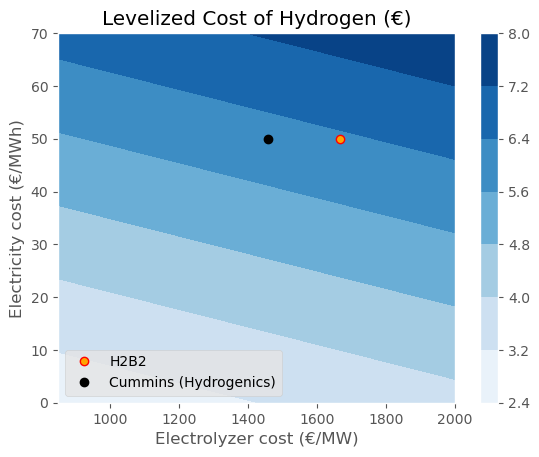

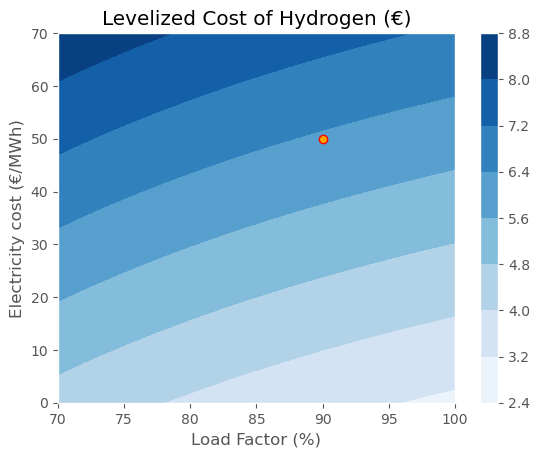

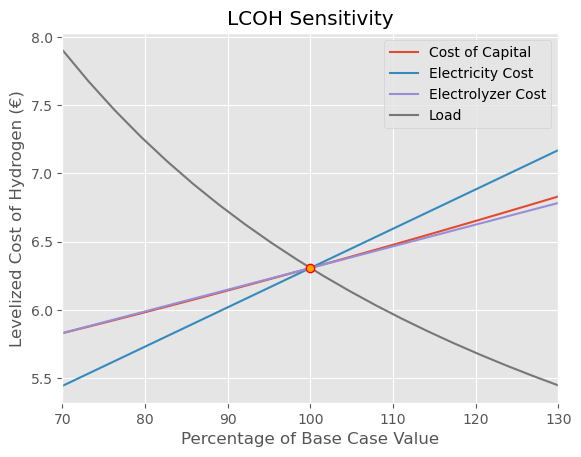

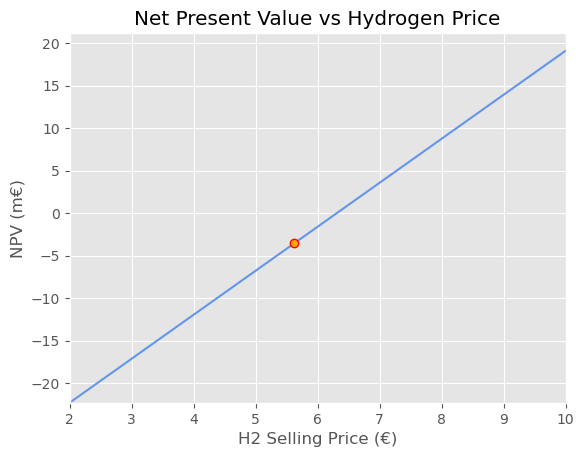

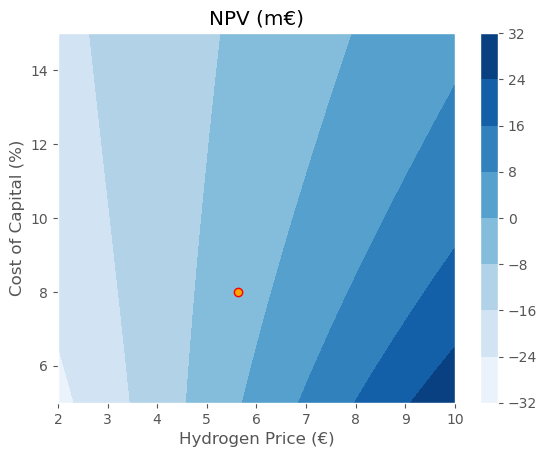

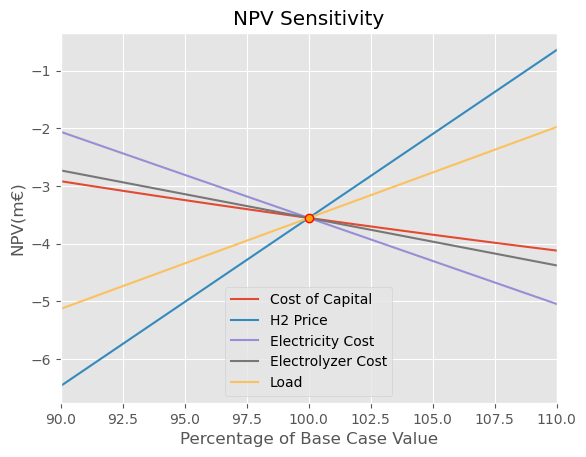

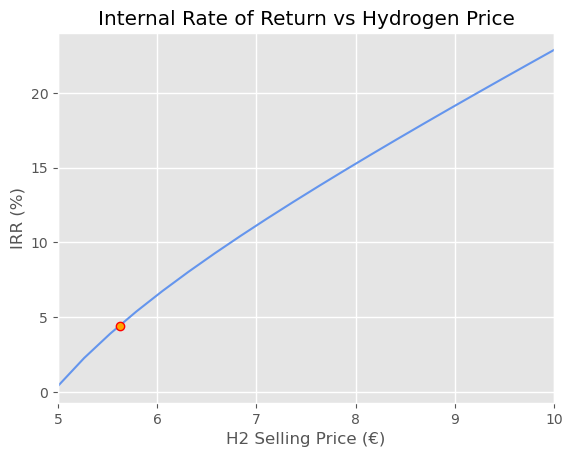

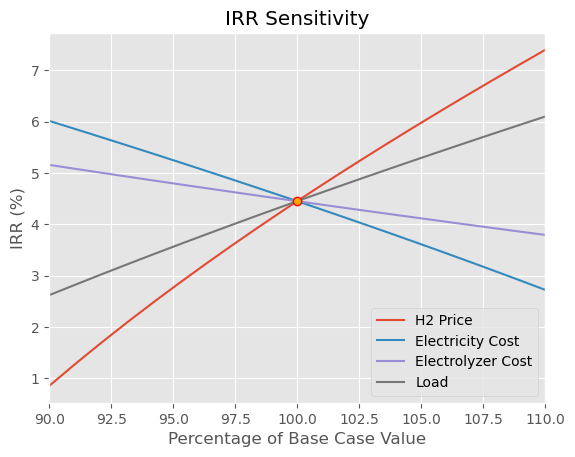

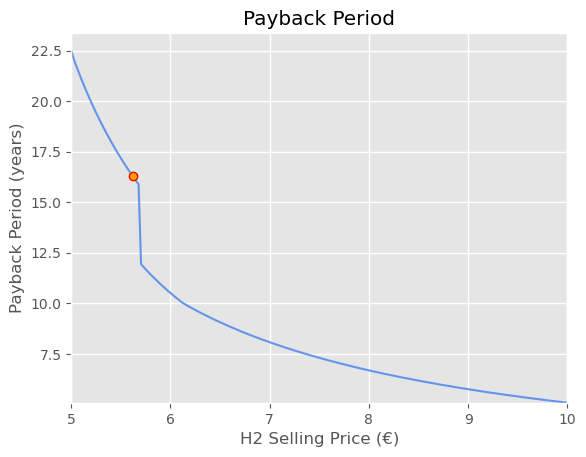

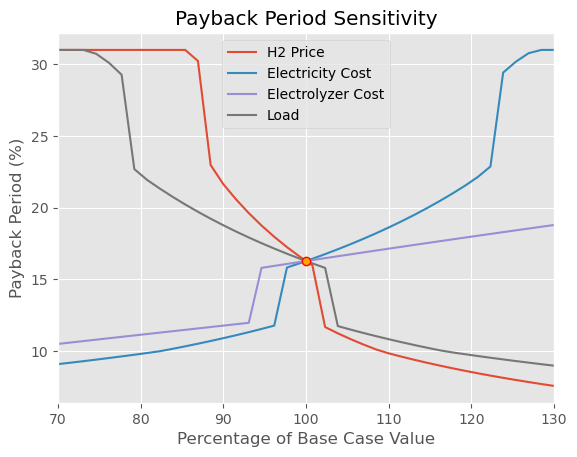

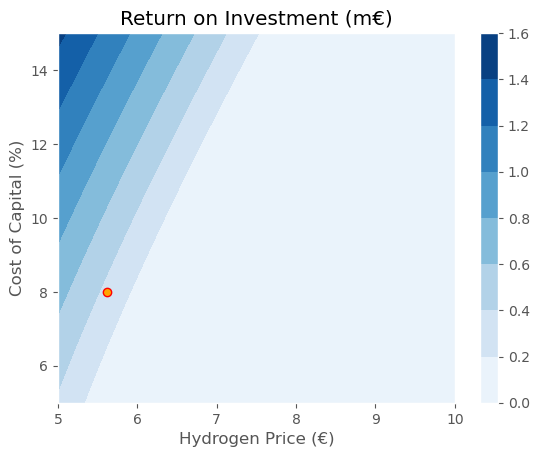

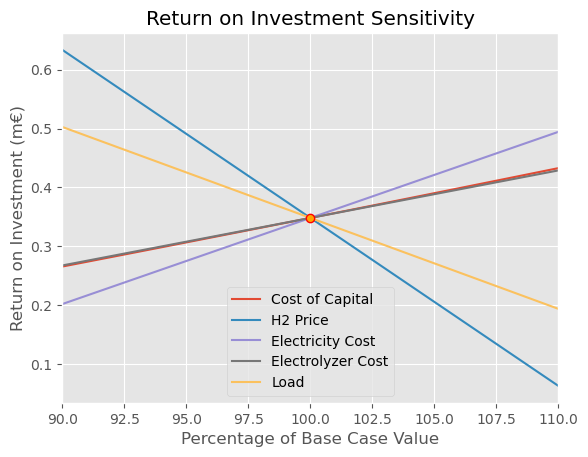

In [10]:
directory = os.getcwd() + '\\python CF Analysis\\images'
ha.exportPlots(hydrogen, generalSpecs, inflation_factors, tax_rate, directory)

### Sensibility tables

In [11]:
table_name = 'LCvsElectrolyzerAndElectricity.csv'
df = pd.read_csv(os.getcwd() + '\\python CF Analysis\\images\\' + table_name, index_col=0, sep=",")
print('LCOH vs electricity (vertical) and electrolyzer costs (horizontal)')
df

LCOH vs electricity (vertical) and electrolyzer costs (horizontal)


,850.0,1092.11,1334.21,1576.32,1818.42
58.95,6.04,6.27,6.50,6.74,6.97
44.21,5.19,5.42,5.66,5.89,6.12
29.47,4.35,4.58,4.81,5.04,5.27
14.74,3.50,3.73,3.96,4.19,4.42
0.00,2.65,2.88,3.11,3.34,3.57


In [12]:
table_name = 'LCvsLoadAndElectricity.csv'
df = pd.read_csv(os.getcwd() + '\\python CF Analysis\\images\\' + table_name, index_col=0, sep=",")
print('LCOH vs electricity cost (vertical) and load factor (horizontal)')
df

LCOH vs electricity cost (vertical) and load factor (horizontal)


,70.0,76.32,82.63,88.95,95.26
58.95,7.89,7.49,7.15,6.87,6.62
44.21,7.04,6.64,6.31,6.02,5.77
29.47,6.19,5.79,5.46,5.17,4.92
14.74,5.34,4.94,4.61,4.32,4.07
0.00,4.49,4.09,3.76,3.47,3.22


### More sensibility plots

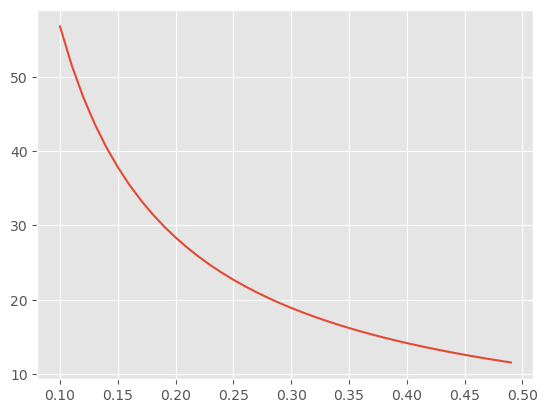

In [13]:
#### SENSITIVITY TO LOAD FACTORS ########
plt.figure(1)

load_factors = np.arange(10,50,1)/100
lcoh_array = np.array([])

normal_load = hydrogen.main_product.load_factor

for load in load_factors:
    hydrogen.main_product.load_factor = load
    lcoh_array = np.append(lcoh_array,[hydrogen.getLC(0.3,inflation_factors)])


hydrogen.main_product.load_factor = normal_load
plt.plot(load_factors,lcoh_array)

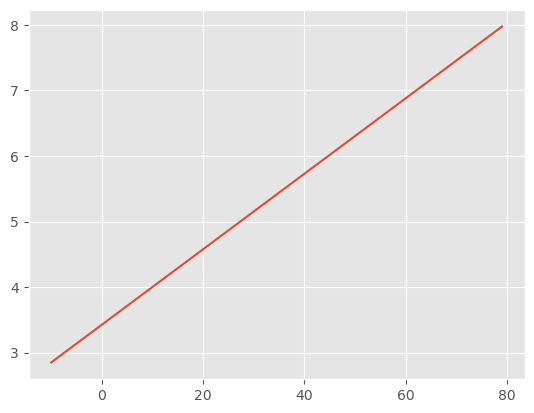

In [14]:
##### SENSITIVITY TO ELECTRICITY PRICE #####
plt.figure(2)



el_prices = np.arange(-10,80,1)
lcoh_array = np.array([])

normal_el_price = el.price

for el_price in el_prices:
    el.price = el_price
    hydrogen.addFeedstockCosts(generalSpecs.utilities_and_materials_dict)
    lcoh_array = np.append(lcoh_array,[hydrogen.getLC(0.3,inflation_factors)])

el.price = normal_el_price
plt.plot(el_prices,lcoh_array)

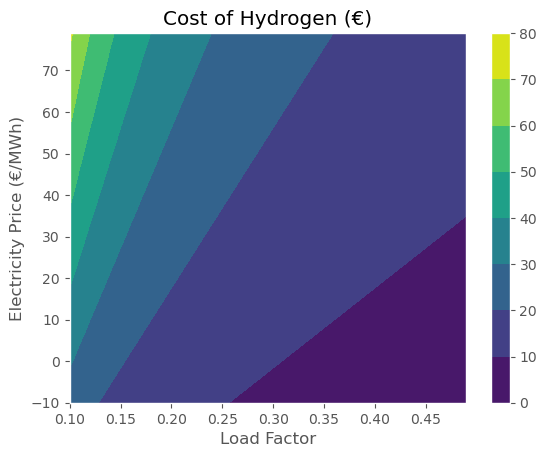

In [15]:
##### SENSITIVITY TO LOAD FACTOR AND EL. PRICE #####
fig = plt.figure(3)

lcoh_array = np.zeros((len(el_prices),len(load_factors)))

xv, yv = np.meshgrid(load_factors,el_prices)
for x in range(len(load_factors)):
    for y in range(len(el_prices)):
        hydrogen.main_product.load_factor = load_factors[x]
        el.price = el_prices[y]
        
        hydrogen.addFeedstockCosts(generalSpecs.utilities_and_materials_dict)
        
        lcoh_array[y][x] = hydrogen.getLC(0.3,inflation_factors)
        
        
surf = plt.contourf(xv, yv, lcoh_array)
plt.xlabel('Load Factor')
plt.ylabel('Electricity Price (€/MWh)')
plt.title('Cost of Hydrogen (€)')
plt.colorbar()
